# OBJECT DETECTION IA 
## (Classification only -> No localisation) 
### DeepLearning Network using CNN transfert learning with a classifier that I add
### The goal is to detect human body in a video-surveillance cam

# DATA
## Import

In [1]:
from matplotlib import pyplot as plt

import torch
from torchvision import datasets, transforms

import helper #pymodule that I add to print image from dataloader

## Download dataset
###### Do not re-execute this cell

In [2]:
#DO NOT RE-EXECUTE THIS CELL

#Download kaggle dataset

#uncomment the next line to download the dataset
#!kaggle datasets download -p "data/raw" --unzip --force constantinwerner/human-detection-dataset/version/3



## Transform & LOAD data
we doesn't have to transform much the data, all images are already 256*256 px

In [4]:
data_dir = "data/kaggle_ConstantinWerner"

#transform
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                #transforms.Grayscale(),
                                transforms.ToTensor()])
#maybe add normalisation -> transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5]) 
                                                            

#load (with ImageFolder)
train_dataset = datasets.ImageFolder(data_dir + "/train", transform=transform)
test_dataset = datasets.ImageFolder(data_dir + "/test", transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=True)

#### Show an image

images shape :  torch.Size([20, 3, 256, 256])
image  shape :  torch.Size([3, 256, 256])
labels shape :  torch.Size([20])


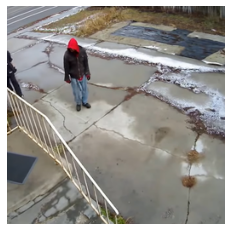

In [5]:
images, labels = next(iter(train_dataloader))
image = images[0]
helper.imshow(image, normalize=False)

print("images shape : ", images.shape)
print("image  shape : ", image.shape)
print("labels shape : ", labels.shape)

## Transform and Load VALICA dataset

In [6]:
data_dir2 = "data/homemade_Valica"

#transform
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])
#maybe add normalisation -> transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5]) 
                                                            

#load (with ImageFolder)
test_valica_dataset = datasets.ImageFolder(data_dir2, transform=transform)

test_valica_dataloader = torch.utils.data.DataLoader(test_valica_dataset, batch_size=20, shuffle=True)

#### Show an image

images type :  torch.Size([20, 3, 256, 256])
labels type :  torch.Size([20])


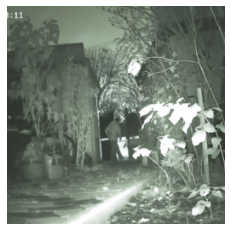

In [7]:
images, labels= next(iter(test_valica_dataloader))

helper.imshow(images[0], normalize=False)

print("images type : ", images.shape)
print("labels type : ", labels.shape)

# MODEL

## Import

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import models

from collections import OrderedDict

import time

## Load pretrained model

In [4]:
model = models.densenet121(pretrained=True)

## Create classifier

In [5]:
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024,512)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.2)),
    ('fc2',nn.Linear(512,2)),
    ('output', nn.LogSoftmax(dim=1))
    ]))

criterion = nn.NLLLoss()

#Add our classifier to our pretrained network
model.classifier = classifier

## Train model
### Pre-train

In [6]:
#GPU available ?
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Train on GPU")
else:
    device = torch.device("cpu")
    print("Train on CPU")
    

#Freeze model parameters (not classifier parameters) (transfert learning)
#Possibly don't freeze last layer parameters ? State of last(s) layer: freeze
for param in model.parameters():
    param.requires_grad = False


#move model on the right device
model.to(device)

#Activate grad (udaptabilty) for the classifier parameters
for param in model.classifier.parameters():
    param.requires_grad = True

#optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001) 

Train on GPU


### Choose you train and test dataloader

In [13]:
#TEST DATALOADER

#choose you dataloader -> test_ &autocompletion OR train_ &autocompletion
a_test_dataloader = test_valica_dataloader

In [14]:
#TRAIN DATALOADER

#choose you dataloader -> test_ &autocompletion
a_train_dataloader = train_dataloader

### Train
We have : train_dataloader & test_dataloader  

In [49]:
epochs = 30
model_name = "YOUR_MODEL_NAME"  #CHOOSE YOUR MODEL NAME FOR AUTO-SAVING

min_test_epoch_loss = 1000
max_accuracy = 0

t0 = time.time()

for e in range(epochs):
    
    #TRAIN
    epoch_loss = 0
    model.train()
    for images, labels in train_dataloader:
        
        optimizer.zero_grad() #delete gradients of the last backward pass
        
        images,labels = images.to(device), labels.to(device) #move tensors in gpu if available
        
        output = model.forward(images) #forward pass
        
        loss = criterion(output, labels) #calculate loss
        
        loss.backward()   #calculate gradient of the loss function
        
        optimizer.step()  #update weights (using gradients)
        
        epoch_loss += loss.item()
      
    
    #TEST
    model.eval()
    accuracy = 0
    ten = torch.empty(0,1).to(device)
    test_epoch_loss = 0
    with torch.no_grad():
        for images, labels in a_test_dataloader:
            images, labels = images.to(device), labels.to(device)
            
            #inference
            output = model.forward(images)
            
            #accuracy
            proba = torch.exp(output)
            top_p, top_class = proba.topk(1, dim=1)
            equal = top_class == labels.view(*top_class.shape)
            ten = torch.cat((ten,equal),0)
            
            #test_loss
            test_loss = criterion(output, labels)
            test_epoch_loss += loss.item()
            
        accuracy = torch.mean(ten).item()*100
     
    #print statistics
    print("epoch ", e, " || loss = ", round(epoch_loss, 2)," || test_loss = ", round(test_epoch_loss,2)," ||Accuracy = ", round(accuracy,2),"%")
    
    #saving model
    if(test_epoch_loss < min_test_epoch_loss):
        min_test_epoch_loss = test_epoch_loss
        max_accuracy = accuracy
        torch.save(model.state_dict(), "trained_models/auto/" + model_name)
        print("Saving model at this point")
            
tf = time.time() - t0
            
print("Train over ! -> ",round(tf,2)," sec") 
print("Your model reach ", round(max_accuracy,2),"%", "of accuracy on the test dataset with a minimum (test)loss of ", round(min_test_epoch_loss,2) )

#Load best model
model.load_state_dict(torch.load("trained_models/auto/" + model_name))

KeyboardInterrupt: 

## TEST MODEL
### Accuracy test (on the whole test_dataset)

In [14]:
#choose you dataloader -> test_ &autocompletion
a_dataloader = test_valica_dataloader

model.eval()

accuracy = 0
i = 0
with torch.no_grad():
    for images, labels in a_dataloader:
        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)

        proba = torch.exp(output)


        top_p, top_class = proba.topk(1, dim=1)
        equal = top_class == labels.view(*top_class.shape)
        accuracy += torch.sum(equal).item()
    print("accuracy =",(accuracy/(len(a_dataloader.dataset)))*100,"%")

accuracy = 81.53153153153153 %


### Test visualisation

In [52]:
import time

#choose you dataloader -> test_ &autocompletion
a_dataloader = test_valica_dataloader

It's a human at  5.89 %    -> compute in 0.0239 sec


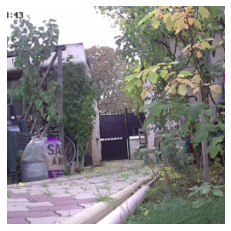

In [41]:
images, labels = next(iter(a_dataloader))
device = "cuda"
i = 1

image = images[i].view([1,3,256,256])
label = labels[i]

helper.imshow(image.view([3,256,256]).cpu(), normalize=False)

model = model.to(device)
images = images.to(device)
image = images.to(device)
label = labels.to(device)



model.eval()
t0 = time.time()
with torch.no_grad():
    output =  model.forward(image)
    proba = torch.exp(output)
t1 = time.time() - t0
    
print("It's a human at ", round(proba[i,0].item()*100,2), "%    -> compute in", round(t1, 4),"sec")

    

## Saving model on demand

In [310]:
#DON'T FORGOT TU NAME YOUR MODEL
model_name = "adam_0.01_ConstantinWarner_drop0.02"
torch.save(model.state_dict(), "trained_models/" + model_name)

# Other way to save a model (not-recommended)
#torch.save(model, "trained_models/autremodel")

## Load model on demand

In [13]:
#Which mode do you want to load ?
model_name = "adam_0.01_ConstantinWarner_drop0.02"
model.load_state_dict(torch.load("trained_models/" + model_name))

<All keys matched successfully>

## Test du model dans un flux vidéo
### Import

In [28]:
import numpy as np
import cv2
import imutils
import torch
import helper

### Set up

In [29]:
height = 750
width = 750


transform = transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(256)])

def sigmoid(x):
    return 1/(1+1*torch.exp(-x))

model = model.to(device)
model = model.eval()

### Run webcam 

In [36]:
cv2.startWindowThread()  

cap = cv2.VideoCapture(0)  # open webcam video stream

i = 0
while(True):
    i += 1
    ret, frame = cap.read() # Capture frame-by-frame
    
    frame = cv2.resize(frame, (width,height)) # resizing for faster detection
    
    
    #boxes = np.array([[x, y, x + w, y + h] for (x, y, w, h) in boxes])

    #for (xA, yA, xB, yB) in boxes:
        # display the detected boxes in the colour picture
    
            
    if(i == 15):
        i = 0
        #Convert opencv frame into tensor for Pytorch model
        with torch.no_grad():
            
        
            tf = torch.from_numpy(frame)  #convert  torch.tensor into numpy.array
            
            tf = tf.to(device)            #put in GPU
            
            #Some transform to adapt the input
            tf = tf.permute(2,0,1)    
            tf = transform(tf)
            tf = torch.Tensor.float(tf)
            mean, std = tf.mean(), tf.std()
            tf = transforms.Normalize(mean,std).forward(tf)
            tf = sigmoid(tf)
            tf = tf.view(1,3,256,256)

            
            output = model.forward(tf) #Forward pass
            proba = torch.exp(output)  # interprate the output
            percent = proba[0,0].item()*100  # in probability
            
            
            #print("HUMAN : ",round(percent,2), "%")  # print confidence percentage of the AI
          

        #Print boxes (red or green)
    if(percent > 50):
        cv2.rectangle(frame, (0, 0), (width,height),(0, 255, 0), 7)
    else:
        cv2.rectangle(frame, (0, 0), (width,height),(0, 0, 255), 7)
    
    frame = cv2.flip(frame, 1)  # Flip the fram horizontally
    
    cv2.imshow('frame',frame)  # Display the resulting frame
    
    # Exit -> press 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
        

# When everything done, release the capture
cap.release()

# finally, close the window
cv2.destroyAllWindows()
cv2.waitKey(1)

-1